The great thing about PyTorch Geometric is that it contain useful functionalities to import and load graph related data.

In [1]:
import torch
from torch_geometric.data import Data

Now let's create an unweighted and undirected graph with three nodes and four total edges.

In [2]:
edge_index = torch.tensor([[0,1,1,2],[1,0,2,1]],dtype=torch.long)
x = torch.tensor([[-1],[0],[1]])
data = Data(x=x,edge_index=edge_index)
print(data)

Data(x=[3, 1], edge_index=[2, 4])


Our data object Data has many useful utility functions to check the properties of the graph. 

In [3]:
print(data.num_edges)

4


In [4]:
print(data.num_nodes)

3


In [5]:
print(data.num_features)

1


In [6]:
print(data.is_directed())

False


Loading Data

Find more fun functions related to graph data here.

One of the cool things about the PyTorch Geometric library is that it contains out-of-the-box benchmark datasets that are ready to use and explore. A popular dataset is the Cora dataset that is used for supervised graph node classification. (We will talk about these applications in an upcoming tutorial but for now we will focus on the data itself).

"The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words." - Papers with Code.

Let's load the Cora dataset:

In [8]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='tmp/Cora',name='Cora')

Processing...
Done!


In [9]:
print('Numberof graphs:',len(dataset))
print('Number of features:',dataset.num_features)
print('Number of classes:',dataset.num_classes)

Numberof graphs: 1
Number of features: 1433
Number of classes: 7


We can see that this particular graph dataset only contains one graph. Graph data can be very complex and can include multiple graphs depending on the type of data and application. Let's check more feature of the Cora dataset:

In [10]:
data = dataset[0]

print('Number of nodes:',data.num_nodes)

print('Number of edges',data.num_edges)

print('Is directed:',data.is_directed())


Number of nodes: 2708
Number of edges 10556
Is directed: False


You can sample nodes from the graph this way:

In [11]:
print('shape of sample nodes:',data.x[:5].shape)

shape of sample nodes: torch.Size([5, 1433])


We extracted 5 nodes from the graph and checked its shape. You will see that each node has 1433 features.

Another great advantage of using PyTorch Geometric to load the Cora data is that it comes pre-processed and ready to use. It also has the splits for training, validation and test which we can directly use for training a GNN.

Let's check some stats for the partitions of the data:


In [12]:
print('Nodes to train:',data.train_mask.sum().item())
print('Nodes to test:',data.test_mask.sum().item())
print('Nodes to validate:',data.val_mask.sum().item())

Nodes to train: 140
Nodes to test: 1000
Nodes to validate: 500



That information is important as it will indicate to our model which nodes to train against and which to test against, and so on.

When training neural networks we train them using batches of data. PyTorch Geometric provides efficient processes to load batches of data.

PyTorch Geometric contains a data loader which is a very popular feature in PyTorch to efficiently load data when training neural networks.

So let's try to load the data using the built in DataLoader:


In [13]:
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
print(device)

cpu


In [15]:
dataset = Planetoid(root='tmp/Cora',name='Cora')
data = dataset[0].to(device)


Print some quick statistics about the data:


In [16]:
print('X shape:',data.x.shape)
print('Edge shape:',data.edge_index.shape)
print('Y shape:',data.y.shape)

X shape: torch.Size([2708, 1433])
Edge shape: torch.Size([2, 10556])
Y shape: torch.Size([2708])


Model and Training

Finally, let's define a standard GCN to train on the Cora dataset. The aim is to train a model that gets better at predicting the class of the node.

To keep thins simple we will use the same model definition as used in the tutorial we adpated the code from. Note that we are using the built-in GCNConv model but you could easily implement your own (something we will cover in a future tutorial).

The model below uses two GCNConv layers. The first layer is followed by a non-linearity ReLU and Dropout. The result is fed to the second layer on top of which we apply Softmax to get distribution over the number of classes.

In [17]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        """Graph convolution network(GCN)"""
        self.conv1 = GCNConv(data.num_features,16)
        self.conv2 = GCNConv(16,dataset.num_classes)
    
    def forward(self,data):
        x,edge_index = data.x,data.edge_index
        x = self.conv1(x,edge_index)
        x = F.relu(x)
        x = F.dropout(x,training=self.training)
        x = self.conv2(x,edge_index)
        
        return F.log_softmax(x, dim=1)

Initial model and optimizer

In [18]:
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=5e-4)

Define accuracy function for evaluating performance:

In [19]:
def compute_accuracy(pred_y, y):
    return (pred_y == y).sum()

And finally we train the model on the train in nodes for 200 epochs

In [20]:
model.train()
losses =[]
accuracies = []
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    
    loss = F.nll_loss(out[data.train_mask],data.y[data.train_mask])
    correct = compute_accuracy(out.argmax(dim=1)[data.train_mask],data.y[data.train_mask])
    acc = int(correct) / int(data.train_mask.sum())
    losses.append(loss.item())
    accuracies.append(acc)
    
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print('Epoch: {}, Loss: {:.4f}, Trainin Acc: {:.4f}'.format(epoch+1,loss.item(),acc))
        

Epoch: 10, Loss: 0.8320, Trainin Acc: 0.8857
Epoch: 20, Loss: 0.2102, Trainin Acc: 0.9857
Epoch: 30, Loss: 0.1496, Trainin Acc: 0.9643
Epoch: 40, Loss: 0.0712, Trainin Acc: 0.9857
Epoch: 50, Loss: 0.0364, Trainin Acc: 1.0000
Epoch: 60, Loss: 0.0499, Trainin Acc: 0.9929
Epoch: 70, Loss: 0.0432, Trainin Acc: 1.0000
Epoch: 80, Loss: 0.0544, Trainin Acc: 1.0000
Epoch: 90, Loss: 0.0365, Trainin Acc: 0.9929
Epoch: 100, Loss: 0.0335, Trainin Acc: 1.0000
Epoch: 110, Loss: 0.0369, Trainin Acc: 1.0000
Epoch: 120, Loss: 0.0332, Trainin Acc: 1.0000
Epoch: 130, Loss: 0.0333, Trainin Acc: 1.0000
Epoch: 140, Loss: 0.0211, Trainin Acc: 1.0000
Epoch: 150, Loss: 0.0263, Trainin Acc: 1.0000
Epoch: 160, Loss: 0.0352, Trainin Acc: 0.9929
Epoch: 170, Loss: 0.0298, Trainin Acc: 1.0000
Epoch: 180, Loss: 0.0401, Trainin Acc: 0.9929
Epoch: 190, Loss: 0.0173, Trainin Acc: 1.0000
Epoch: 200, Loss: 0.0187, Trainin Acc: 1.0000


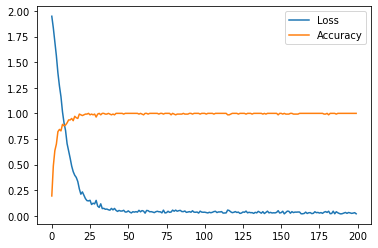

In [21]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(accuracies)
plt.legend(['Loss','Accuracy'])
plt.show()

It looks like the model achieves a very high accuracy and small loss on the training dataset.



In [22]:
model.eval()
pred = model(data).argmax(dim=1)
correct = compute_accuracy(pred[data.test_mask],data.y[data.test_mask])
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7960
